<a href="https://colab.research.google.com/github/gmmendez/EA2SOA/blob/master/EA3_Mendez_Gonzalo_39913544_Ejercicio1_GPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**1. Introduccion**

La *dotación de riego* es una medida usada para calcular, teóricamente, cuanta superficie se podría regar en función del agua disponible y se expresa en milímetros por hectárea por hora. Da una idea aproximada sobre cuanta superficie se podría regar, o sea las posibilidades reales de riego. Se obtiene dividiendo el caudal disponible expresado en litros por segundo por 2,78 (un coeficiente para convertir las unidades utilizadas).

Supongamos que disponemos de una bomba eléctrica monofásica que arroja 4.000 litros por hora que equivalen a 1,11 lts/seg (4.000/3.600 segundos = 1,11 litros por segundo). Para convertir esta medida en dotación de riego se divide la cantidad de litros que expende la bomba por segundo por 2,78



> *Dotación de riego = cantidad de litros por segundo / 2,78*



> *Dotación de riego = 1,11 lts / 2,78 = 0,4 mm/Ha/h.*


De esta forma, se puede establecer cuanto tiempo llevará regar una -o más de una- hectárea(s) dependiento de la cantidad de agua diaria que necesite el cultivo. Supongamos que una hectárea de plantación de soja requiere unos 7 mm de agua diarios, entonces se puede establecer que la cantidad de horas que debe estar en funcionamiento la bomba eléctrica será:



> *Requerimiento / Dotación = 7/0,4 = 17,5 horas (duración diaria de una operación).*

El siguiente ejercicio tiene como objetivo realizar el cálculo de la cantidad de horas que deben mantenerse en funcionamiento distintas bombas eléctricas de agua que se utilizan en hectáreas de diferentes cultivos utilizando la potencia de cálculo de GPGPU. El ejercicio simula mediante el vector requerimientoHectarea la cantidad de milímetros de agua que necesita una hectárea de un determinado cultivo, mientras que el vector dotacionBombaAgua simula la cantidad de litros de agua por hora que expende la bomba eléctrica de agua que se utiliza en dicha hectárea, es decir, en la posición 0 del vector dotacionBombaAgua encontraremos la cantidad de litros de agua expendidos por la bomba utilizada en el cultivo de la hectárea que se encuentra en la posición 0 del vector requerimientoHectarea.

**2. Armado de ambiente**

Para poder utilizar la capacidad de procesamiento de los CUDA Core que ofrece la plataforma Colab, previamente se debe instalar en la misma el módulo CUDA para python llamado pycuda. 
PyCUDA brinda un fácil acceso a la API de cálculo paralelo CUDA de Nvidia.

In [ ]:
!pip install pycuda

     |████████████████████████████████| 1.6MB 13.1MB/s 
     |████████████████████████████████| 71kB 11.7MB/s 
     |████████████████████████████████| 81kB 13.3MB/s 
  Created wheel for pycuda: filename=pycuda-2020.1-cp36-cp36m-linux_x86_64.whl size=621008 sha256=948a8b750bca020ff7a8f8e8e81af0a21c37d5489b925778e26caaf012560fb0
  Stored in directory: /root/.cache/pip/wheels/8f/78/d1/5bb826f81d9d490297a348d818ff3ee6dd6f2075b06dde6ea0
  Created wheel for pytools: filename=pytools-2020.4.3-py2.py3-none-any.whl size=61374 sha256=47b84711f658016f6a72d3f72eb3ea8dc999a2c7f587d642cb6608bd1dea2c48
  Stored in directory: /root/.cache/pip/wheels/af/c7/81/a22edb90b0b09a880468b2253bb1df8e9f503337ee15432c64
Successfully built pycuda pytools


**3. Desarrollo**

A continuación se encuentra el código desarrollado para realizar el cálculo de la cantidad de horas que debe estar en funcionamiento cada bomba de agua instalada en las distintas hectareas de cultivo.

In [ ]:
# --------------------------------------------
#@title 3.1 Parámetros de ejecución { vertical-output: true }

cant_hectareas =   100000#@param {type: "number"}
# --------------------------------------------

from datetime import datetime

tiempo_total = datetime.now()

import pycuda.driver as cuda
import pycuda.autoinit
import sys
from pycuda.compiler import SourceModule
from random import randint

import numpy


# Definición de función que transforma el tiempo en  milisegundos
tiempo_en_ms = lambda dt:(dt.days * 24 * 60 * 60 + dt.seconds) * 1000 + dt.microseconds / 1000.0


# CPU - Defino la memoria de los vectores en cpu.
#vector cantidad de milimetros de agua que requiere el cultivo en la hectarea por dia
requerimientoHectarea_cpu = numpy.random.uniform(low=0.3, high=20, size=(cant_hectareas))
requerimientoHectarea_cpu = requerimientoHectarea_cpu.astype( numpy.float32() )

#vector cantidad de litros de agua por hora que expende la bomba de agua instalada en la hectarea
dotacionBombaAgua_cpu = numpy.random.uniform(low=50, high=10000, size=(cant_hectareas))
dotacionBombaAgua_cpu = dotacionBombaAgua_cpu.astype( numpy.int32() )

#vector resultado
resultado_cpu = numpy.zeros_like( requerimientoHectarea_cpu )
resultado_cpu = resultado_cpu.astype( numpy.float32() )
#tiempo_ini_cpu = datetime.now()

# CPU - reservo la memoria GPU.
requerimientoHectarea_gpu = cuda.mem_alloc( requerimientoHectarea_cpu.nbytes )
dotacionBombaAgua_gpu = cuda.mem_alloc( dotacionBombaAgua_cpu.nbytes )
resultado_gpu = cuda.mem_alloc( resultado_cpu.nbytes )

# GPU - Copio la memoria al GPU.
cuda.memcpy_htod( requerimientoHectarea_gpu, requerimientoHectarea_cpu )
cuda.memcpy_htod( dotacionBombaAgua_gpu, dotacionBombaAgua_cpu )
cuda.memcpy_htod( resultado_gpu, resultado_cpu )

# CPU - Defino la función kernel que ejecutará en GPU.
module = SourceModule("""
__global__ void calculoHorasRiegoHectarea( int n, float *Requerimiento, int *Dotacion, float *Resultado )
{
  int idx = threadIdx.x + blockIdx.x*blockDim.x;
  float coeficiente = 2.78;
  float segundos = 3600;
  if( idx < n )
  {
    Resultado[idx] = Requerimiento[idx] / (Dotacion[idx] / segundos / coeficiente);
  }
}
""")
# CPU - Genero la función kernel.
kernel = module.get_function("calculoHorasRiegoHectarea")

tiempo_gpu = datetime.now()

# GPU - Ejecuta el kernel.
dim_hilo = 256

dim_bloque = numpy.int( (cant_hectareas+dim_hilo-1) / dim_hilo )

kernel( numpy.int32(cant_hectareas), requerimientoHectarea_gpu, dotacionBombaAgua_gpu, resultado_gpu, block=( dim_hilo, 1, 1 ),grid=(dim_bloque, 1,1) )

tiempo_gpu = datetime.now() - tiempo_gpu

# GPU - Copio el resultado desde la memoria GPU.
cuda.memcpy_dtoh( resultado_cpu, resultado_gpu )


tiempo_total = datetime.now() - tiempo_total


print( "Thread x: ", dim_hilo, ", Bloque x:", dim_bloque )
print("Tiempo CPU: ", tiempo_en_ms( tiempo_total ), "ms" )
print("Tiempo GPU: ", tiempo_en_ms( tiempo_gpu   ), "ms" )
print("")
print("Requerimiento: ", requerimientoHectarea_cpu)
print("")
print("Dotacion: ", dotacionBombaAgua_cpu)
print("")
print("Resultado: ", resultado_cpu)

Thread x:  256 , Bloque x: 391
Tiempo CPU:  7.996 ms
Tiempo GPU:  0.18 ms

Requerimiento:  [ 8.807673   7.860919  14.982517  ...  9.318309   3.1762173  7.4469066]

Dotacion:  [9001 2577 5319 ... 5883 7401  771]

Resultado:  [ 9.793045  30.528551  28.190454  ... 15.852054   4.2950387 96.6649   ]


**4. Tabla de pasos**



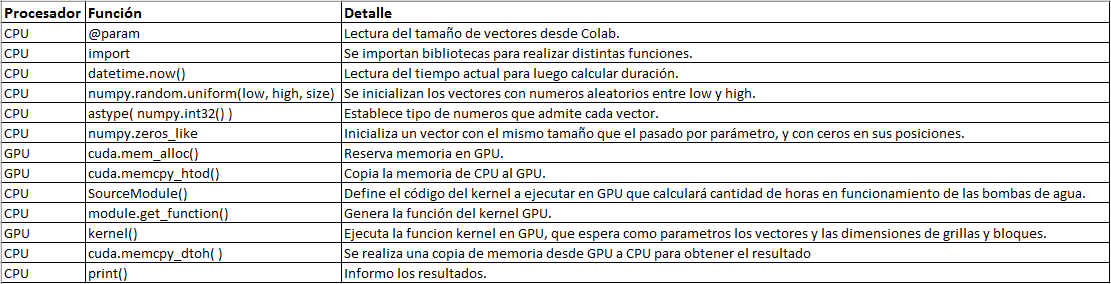

**5. Conclusiones**

*Repaso*

Podemos establecer como resultado de este ejercicio, que la utilización de GPU representa una ventaja a la hora de realizar grandes cantidades de cálculos, ya que cada una de las operaciones para determinar cuantas horas debe mantenerse en funcionamiento cada bomba eléctrica de agua es realizada por un thread GPU. De esta forma, al trabajar tanto con CPU como con un GPU, todo el trabajo secuencial será realizada por la primera (host), mientras que la parte costosa donde se deben ejecutar grandes cantidades de cálculo se ejecuta sobre cada thread de la segunda (device).

Se puede ver que, a pesar de que el host realiza muy poco procesamiento en comparación con el device, el primero toma mayor cantidad de tiempo debido a que las operaciones se realizan de forma secuencial.

En el caso en que no se disponga de una GPU, todo el trabajo caería sobre la CPU y dado que la misma ejecuta las operaciones de forma secuencial, el cálculo sería notablemente más lento. A su vez, a medida que se aumenta la cantidad de hectáreas, el tiempo que tomaría la CPU en finalizar la tarea sería cada vez mayor.

*Lecciones aprendidas*

Este primer ejercicio me permitió aplicar los conocimientos adquiridos en las clases virtuales acerca de la programación en paralelo sobre GPU. Comprendí de que forma se ejecuta cada thread sobre cada núcleo de GPU, y cuales son las estructuras con las que se trabaja en CUDA (grillas, bloques, warps, threads). A su vez, pude verificar a través del resultado de tiempo final la capacidad de cálculo y de trabajo en paralelo de GPU, ya que comparandolo con el resultado de la ejecucion secuencial (sin utilizar GPU), es notable la diferencia de tiempo.

*Sugerencias para continuar con el ejercicio*

Una sugerencia para continuar el ejercicio puede ser adaptar el mismo a una solución de riego por goteo (*ver EA3_Mendez_Gonzalo_39913544_Ejercicio2.ipynb*) para de esta manera aprovechar aún mejor la capacidad de cálculo de los núcleos GPU (ya que se deben realizar, al menos, cinco cálculos para esta nueva solución), y comparar el tiempo que llevaría aplicar agua a una hectárea por métodos de riego tradicionales (método aplicado en el presente ejercicio) versus el método de riego por goteo, que es considerablemente más eficiente en el uso de agua y, en la mayoría de los casos, igualmente efectivo. La segunda sugerencia que se propone es permitir al productor ingresar cada uno de los valores de las bombas eléctricas de agua que dispone así como también el requerimiento de agua que cada hectárea necesita.

**6. Bibliografía**

[1] Programación en CUDA: [Sitio web](https://riubu.ubu.es/bitstream/handle/10259/3933/Programacion_en_CUDA.pdf;jsessionid=AAD15F54049E00A45B83F863126BD94E?sequence=1)

[2] Tutorial PyCUDA: [Sitio web](https://documen.tician.de/pycuda/tutorial.html)

[3] Hilos CUDA: [Sitio web](https://blog.usejournal.com/cuda-thread-indexing-fb9910cba084)

[4] Documentacion Numpy: [Sitio web](https://numpy.org)

[5] Documentacion PyCUDA: [Sitio web](https://documen.tician.de/pycuda/index.html)